In [1]:
import pandas as pd

df = pd.read_csv('gold_price_data.csv')
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [2]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value,10787.0,653.596634,434.030848,35.1,349.2,409.35,1061.625,1895.0


<Axes: title={'center': 'Value over Time'}, xlabel='Date'>

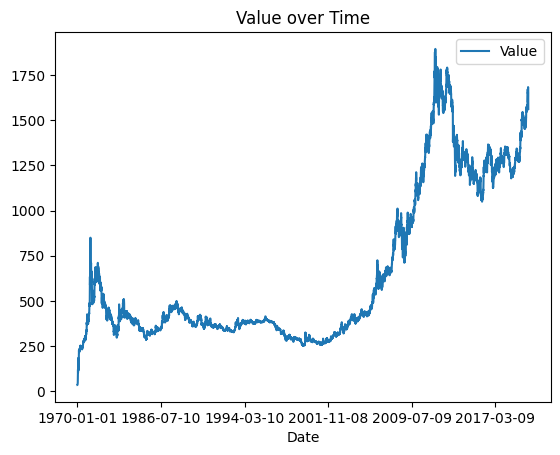

In [3]:
df.plot(x='Date', y='Value', title='Value over Time')

In [4]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df.sort_index(inplace=True)

In [5]:
df

,Value
Date,
1970-01-01,35.20
1970-04-01,35.10
1970-07-01,35.40
1970-10-01,36.20
1971-01-01,37.40
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


### Handling the Mixed Frequency Data

In [6]:
# Extract year from the Date index and create a new column
df['Year'] = df.index.year

# Group by the 'Year' and count the number of occurrences for each year
yearly_counts = df.groupby('Year').size()

# Display the result
print(yearly_counts)


Year
1970      4
1971      4
1972      4
1973      4
1974      4
1975      4
1976      4
1977      4
1978      5
1979    261
1980    262
1981    261
1982    261
1983    260
1984    261
1985    261
1986    261
1987    261
1988    261
1989    260
1990    261
1991    261
1992    262
1993    261
1994    260
1995    260
1996    262
1997    261
1998    261
1999    261
2000    260
2001    261
2002    261
2003    261
2004    262
2005    260
2006    260
2007    261
2008    262
2009    261
2010    261
2011    260
2012    261
2013    261
2014    261
2015    261
2016    261
2017    260
2018    261
2019    261
2020     53
dtype: int64


In [7]:
# Now we have two options
# Option 1: Resample All Data to Quarterly Frequency
# Option 2: Use Only Daily Data (Post-1978)
# Both have their pros and cons, I am going ahead with Option 2

# Filter data starting from 1979 onwards (daily data)
df_daily = df[df['Year'] >= 1979]

df_daily.head()


,Value,Year
Date,,
1979-01-01,226.00,1979
1979-01-02,226.80,1979
1979-01-03,218.60,1979
1979-01-04,223.15,1979
1979-01-05,225.50,1979


### Check for Stationarity

##### Plot the Data

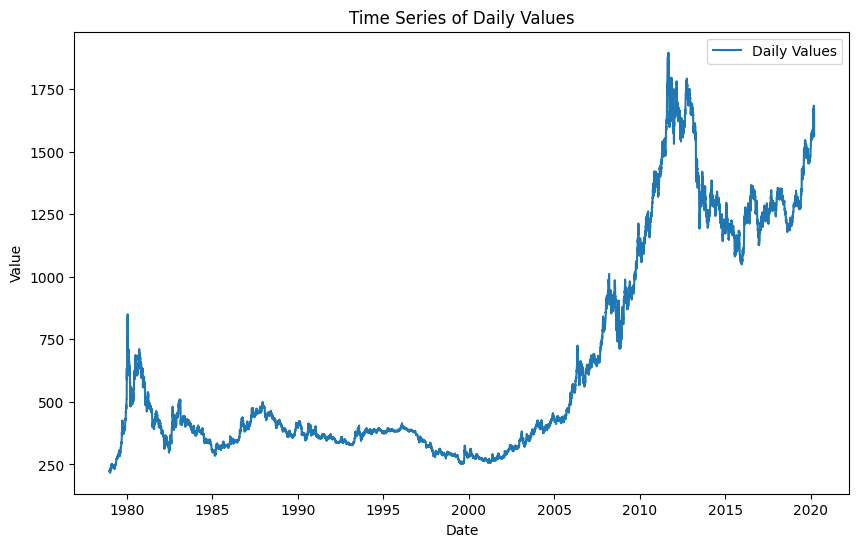

In [8]:
import matplotlib.pyplot as plt

# Plot the Value over time to inspect trends and seasonality
plt.figure(figsize=(10, 6))
plt.plot(df_daily['Value'], label='Daily Values')
plt.title('Time Series of Daily Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

##### Augmented Dickey-Fuller (ADF) Test

In [9]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_daily['Value'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -0.019659952928544486
p-value: 0.9568757071347556


In [10]:
# As we can see the p-value > 0.05, it means that the series is non-stationary
# So we will need to apply differencing to make it stationary

### Differencing the Data

##### Apply First Differencing

In [11]:
df_daily['Value_diff'] = df_daily['Value'].diff() # 1 lag

df_daily.dropna(inplace=True) # for the first NaN value

C:\Users\Kartik\AppData\Local\Temp\ipykernel_6900\892572089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily['Value_diff'] = df_daily['Value'].diff() # 1 lag
C:\Users\Kartik\AppData\Local\Temp\ipykernel_6900\892572089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily.dropna(inplace=True) # for the first NaN value


##### Recheck Stationarity with ADF Test

In [12]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_daily['Value_diff'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -17.456785177223445
p-value: 4.620572537106384e-30


In [13]:
# As we can see now the p-value is much smaller than 0.05, 
# so we conclude that the data is stationary now.

### Identify SARIMAX Parameters

In [14]:
# d = 1 , as we calculated
# (p, d, q) the non-seasonal ARIMA components
# (P, D, Q, s) the seasonal components

##### Use ACF and PACF Plots

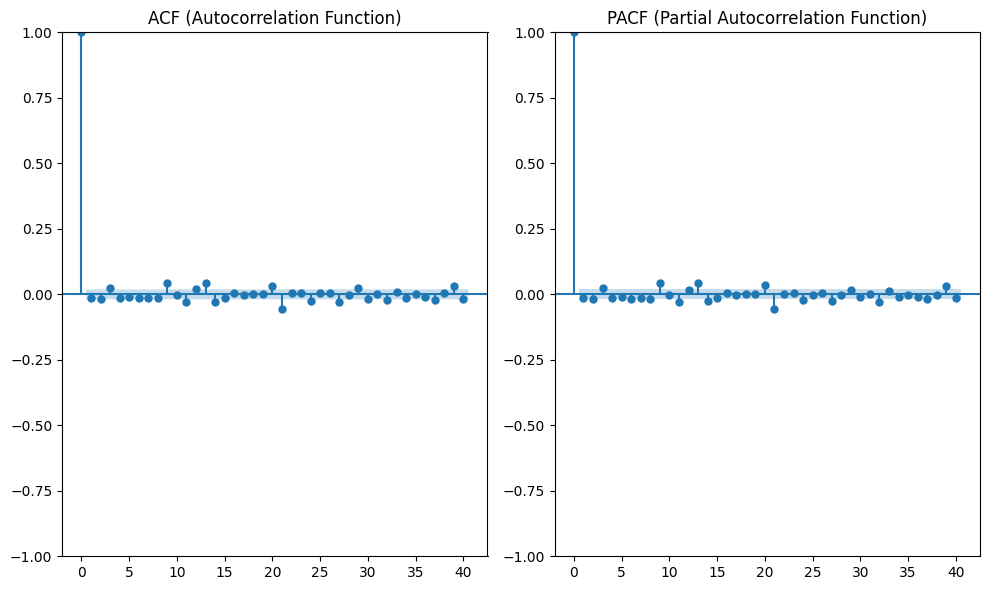

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))

# ACF
plt.subplot(1,2,1)
plot_acf(df_daily['Value_diff'], ax=plt.gca(), lags=40)
plt.title('ACF (Autocorrelation Function)')

# PACD
plt.subplot(1,2,2)
plot_pacf(df_daily['Value_diff'], ax=plt.gca(), lags=40)
plt.title('PACF (Partial Autocorrelation Function)')
plt.tight_layout()

### Fit the SARIMAX Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_daily['Value'],
               order=(1,1,1),
               seasonal_order=(1,1,1,365)
               )


results = model.fit(maxiter=50,disp=1)
results.summary()

C:\Users\Kartik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\Kartik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [ ]:
results.plot_diagnostics(figsize=(14, 10))
plt.show()

### Make Predictions

##### In-sample prediction

In [ ]:
predictions = results.predict(start=0, end=len(df_daily)-1, dynamic=False)
plt.figure(figsize=(10, 6))
plt.plot(df_daily['Value'], label='Actual Data')
plt.plot(predictions, label='Predicted Data', linestyle='--')
plt.title('In-sample Predictions vs Actual Data')
plt.legend()
plt.show()
